# -----------------------------------------------------
# Raiders of the Lost Plateau 
## PBC
### Created:   April 2018 
### Modified: November 2018
# -----------------------------------------------------

0. The matrix C(t) is periodic and traslation invariant. Statistical error have been further reduced by averaging this matrix along diagonals. The pbc.py is the script we have used to increased the statistics. The matrix loaded in this notebook has previously "passed through" this script. 
1. Momentum correlations are computed from simulations with a time step 0.002, while the time step is 0.004 for the
   simulations in which the correlations of the stress tensor are computed. We carefully distinguis between $dt$ and $dtStress$
2. Compute the integral of the correlations using the trapezoidal rule instead of the operator: 

  \begin{array}{cccc}
   1 & 0 & 0 & 0\\
   1 & 1 & 0 & 0\\
   1 & 1 & 1 & 0\\
   1 & 1 & 1 & 1\\
  \end{array}

# 0. STUFF

## 0.1. Packages

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm
from scipy import linalg
from numpy import linalg as LA
from numpy.linalg import inv
import scipy.integrate as integrate

## 0.2. Plot style

In [5]:
# Plot style
sns.set_style("ticks")
# Create palette
thesisPalette = ["royalblue", "darkorange", "darkmagenta", "seagreen", "deeppink", "dimgrey", "darkkhaki", "darkblue", "gold","mediumpurple", "teal"]
sns.set_palette(thesisPalette)
#Font and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.0})
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
size1Fig = 6.4,5
size2Fig = 14,5

## 0.3. Files

In [6]:
Ct          = np.loadtxt('Ct-PBC-1000steps.dat')   # t=2
Sxzt        = np.loadtxt('Sxzt-PBC-1000steps.dat') # t=4
Ct_mu30nu31 = np.loadtxt('Ct-gxTh-mu30nu31')       # t=50
Ct_mu30nu30 = np.loadtxt('Ct-gxTh-mu30nu30')       # t=50

## 0.4. Parameters

In [7]:
nSteps       = np.shape(Ct)[0]
nStepsStress = np.shape(Sxzt)[0]
nStepsPred   = np.shape(Ct_mu30nu30)[0]
nCols        = np.shape(Ct)[1]
nNodes       = int(np.sqrt(nCols))
nBlocks      = 1                                                            
nVar         = int(np.sqrt(nBlocks))                      
dim          = nVar * nNodes 
dt           = 0.002
dtStress     = 0.004
tol          = 1e-3
Lx, Ly, Lz   = 40.0, 40.0, 30.0
Vol          = Lx * Ly * Lz
dz           = Lz / nNodes  
Temp         = 2.0
density      = 0.6
tau          = 0.2

#Fourier basis and Laplacian in real and Fourier space
E    = np.zeros((nNodes, nNodes), dtype = complex)                  
EInv = np.zeros((nNodes, nNodes), dtype = complex)
for mu in range(nNodes):
    for nu in range(nNodes):
            E[mu,nu]    = np.exp( 1j*2*np.pi*mu*nu/nNodes)/np.sqrt(nNodes)
            EInv[mu,nu] = np.exp(-1j*2*np.pi*mu*nu/nNodes)/np.sqrt(nNodes)

Laplacian           = (1 / dz**2) * (-2 * (np.eye(nNodes)) +\
                    np.eye(nNodes, nNodes, -nNodes+1) + np.eye(nNodes, nNodes, nNodes-1) +\
                    np.eye(nNodes, nNodes, -1) + np.eye(nNodes, nNodes, 1))
LaplacianInv        = linalg.pinv(Laplacian, rcond = tol)
LaplacianFourier    = (EInv.dot(Laplacian).dot(E)).real 
LaplacianInvFourier = linalg.pinv(LaplacianFourier, rcond = tol)

#Forward and backward finite difference operator (for PBC)
F = (1 / dz) * ((-1) * np.eye(nNodes) +  np.eye(nNodes, nNodes, 1) + np.eye(nNodes, nNodes, -nNodes+1))
B = -F.T

## 0.5. Subroutines

In [8]:
#Reshape from vector to matrix
def reshape_vm(A):
    B = A.reshape(nBlocks,nNodes*nNodes).reshape(nVar,nVar,nNodes,nNodes).transpose(0,2,1,3).reshape(dim,dim)
    return B

#Reshape from matrix to vector
def reshape_mv(A):
    B = A.reshape(nVar,nNodes,nVar,nNodes).swapaxes(1,2).ravel()
    return B

#Select the step to which a certain time corresponds
def step(t):
    step = int(round(t/dt))
    return step   

#Select the column to which the autocorrelation of a selected node corresponds
def col(nodeSelected):
    column = (nodeSelected - 1) * nNodes + nodeSelected - 1
    return column

#Replace all values in a matrix < cutOff with zero
def cutOff(A, cutOffValue):
    rows, cols =  np.shape(A)
    B = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            #if abs(A[i,j]) < cutOffValue:
                #A[i,j] = 0
            if A[i,j] > cutOffValue:    #valor absoluto???
                B[i,j] = A[i,j]
    return B

#Replace all values in a matrix equal to zero with NaN 
def zeroToNan(A):
    rows, cols =  np.shape(A)
    for i in range(rows):
        for j in range(cols):
            if A[i,j] == 0:
                A[i,j] = np.nan
    return A

#Take advantage of the PBC for building C(t). The matrices loaded have already increase their statistic with this subroutine.
def pbc(C):
    Cstat = np.zeros((nNodes, nNodes))
    for i in range(nNodes):
        for j in range(nNodes):
            for k in range(nNodes):
                Cstat[i,j] += C[(i+k)%nNodes,(j+k)%nNodes]
    return Cstat/nNodes 

#Smooth C(t)
P = np.eye(nNodes)
for i in np.arange(1,15,1):
    P +=  np.eye(nNodes, nNodes, -nNodes+i) + np.eye(nNodes, nNodes, nNodes-i) +\
    np.eye(nNodes, nNodes, -i) + np.eye(nNodes, nNodes, i)
def smooth(A):
    B = (A + 2.5e-5) * P - 2.5e-5    #Eq.(84) paper Space and time locality of discrete hydrodynamics
    C = B + 4.39991076e-5 / nNodes   #Modification to obtain total momentum equal to zero. P_T=0.
    return C

#Derivative and integral operators. The derivative is in compliance with the Barrow rule.
ODev      = np.identity(nSteps) - np.eye(nSteps, nSteps, -1) 
OInt      = np.tril(np.ones((nSteps, nSteps), dtype=float), 0) 
ODev[0,0] = 0
ODev /= dt
OInt *= dt

## 0.6. Smooth $C(t)$ and convert it to an array of 3 dimensions

In [9]:
CtSmooth = np.zeros((nSteps, nNodes**2))
for i in range(nSteps):
    CtSmooth[i:] = reshape_mv(smooth(reshape_vm(Ct[i,:])))
Ct = CtSmooth

Ct3D = np.zeros((nNodes, nNodes, nSteps))
for i in range(nSteps):
    Ct3D[:,:,i] = reshape_vm(Ct[i,:])   
Ct = Ct3D

C0 = Ct[:,:,0]
R = linalg.pinv(C0, rcond = tol)

# 1. REAL SPACE

## 1.1. Compute $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$ and $\Lambda_{\mu\nu}(t)$

In [10]:
CtDev     = np.zeros((nNodes, nNodes, nSteps))
CtInv     = np.zeros((nNodes, nNodes, nSteps))
CtNorm    = np.zeros((nNodes, nNodes, nSteps))
CtNormInv = np.zeros((nNodes, nNodes, nSteps))
Lambdat   = np.zeros((nNodes, nNodes, nSteps))

for i in range(nNodes):
    CtDev[i,:,:] = ODev.dot(Ct[i,:,:].T).T
    
for k in range(nSteps):
    CtInv[:,:,k]     = linalg.pinv(Ct[:,:,k], rcond = tol)
    CtNorm[:,:,k]    = R.dot(Ct[:,:,k])
    CtNormInv[:,:,k] = linalg.pinv(CtNorm[:,:,k], rcond = tol)
    Lambdat[:,:,k]   = - CtDev[:,:,k].dot(CtInv[:,:,k])

#### Plot $C_{\mu\nu}(t)$, $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$  and $\Lambda_{\mu\nu}(t)$

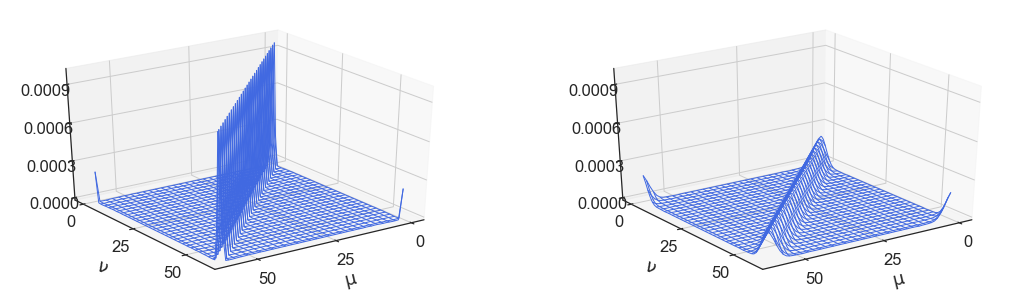

In [11]:
# Select the correct size of the plot
fig = plt.figure()
fig.set_size_inches(18,11)

x = range(nNodes)
y = range(nNodes)

p = 1
for t in np.arange(0, 0.7, 0.6):

    h = fig.add_subplot(2,2,p, projection='3d')
    X, Y = np.meshgrid(x, y) 
    h.plot_wireframe(X, Y, Ct[:,:,step(t)])
    h.set_zlim(0,1e-3)
    h.set_xticks(range(0, 59, 25))
    h.set_yticks(range(0, 59, 25))
    h.set_zticks(np.arange(0, 1e-3, 0.0003))
    #h.set_title(r'$\rm{C_{\mu\nu}('+str(t)+')}$')
    h.set_xlabel(r'$\rm{\mu}$', labelpad=15)
    h.set_ylabel(r'$\rm{\nu}$', labelpad=15)
    #h.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
    h.view_init(30, 55)
    p += 1       
#plt.savefig('../../../figures/Ct-matrix-PBC.pdf'#This is simple recomendation for publication plots
#            ,dpi=1000, 
#            # Plot will be occupy a maximum of available space
#            bbox_inches='tight') 
plt.show()

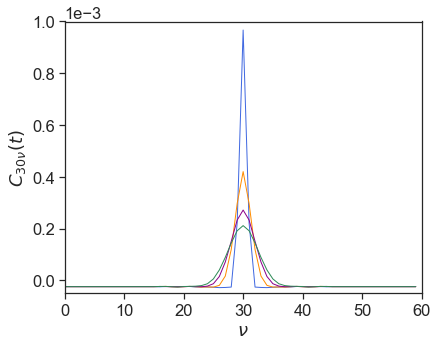

In [12]:
fig = plt.figure()
fig.set_size_inches(size1Fig)
plt.plot(Ct[30,:,step(0)],   label = r'${C(0)_{30\nu}')
plt.plot(Ct[30,:,step(0.2)], label = r'${C(0.2)_{30\nu}')
plt.plot(Ct[30,:,step(0.4)], label = r'${C(0.4)_{30\nu}')
plt.plot(Ct[30,:,step(0.6)], label = r'${C(0.6)_{30\nu}')
plt.xlim(0,60)
plt.ylim(-5e-5,1e-3)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$C_{30\nu}(t)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.legend()
#plt.savefig('../../../figures/Ct-mu30nu-PBC.pdf',dpi=1000, bbox_inches='tight')  
plt.show()

/Users/diego/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/Users/diego/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


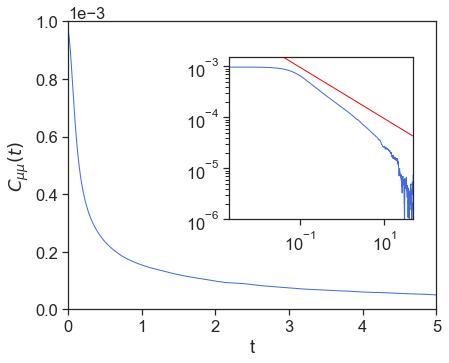

In [13]:
x   = np.arange(0, nStepsPred * dt, dt)
x2  = np.arange(0, np.shape(Ct_mu30nu30)[0] * dt, dt)
fig = plt.figure()
fig.set_size_inches(size1Fig)

# main figure
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])          # main axes
ax1.plot(x, Ct_mu30nu30[:nStepsPred])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xlim([0, 5])
ax1.set_ylim([0, 0.001])
ax1.set_xlabel('t')
ax1.set_ylabel(r'$C_{\mu\mu}(t)$')
# insert
with sns.axes_style("ticks"):
    left, bottom, width, height = 0.45, 0.35, 0.4, 0.45
    ax2 = fig.add_axes([left, bottom, width, height]) # inset axes
    ax2.loglog(x2, Ct_mu30nu30)
    ax2.loglog(x2, 0.0003*x2**(-0.5), color='red')
    ax2.set_xlim([0, 50])
    ax2.set_ylim([1e-6, 0.0015])
#plt.savefig('../../../figures/Ct-mu30nu30-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

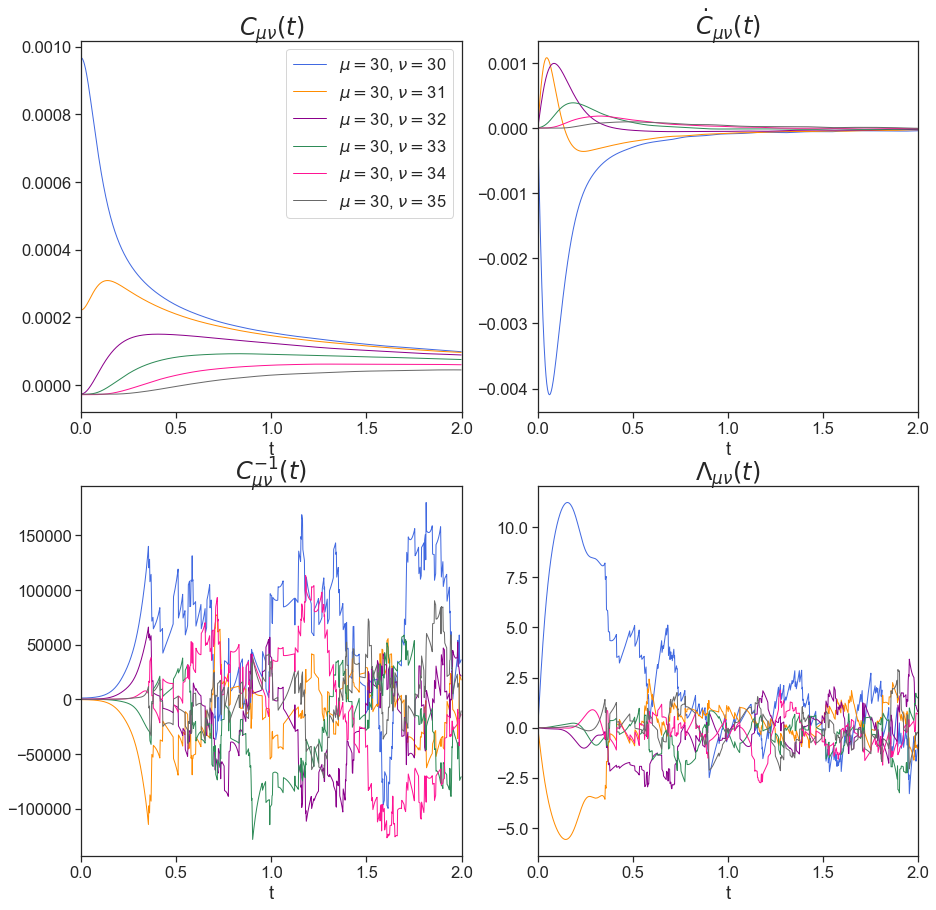

In [14]:
x  = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(15,15))

plt.subplot(221)
for i in range(6):
    plt.plot(x, Ct[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
plt.legend(loc='upper right')

plt.subplot(222)
#f  = plt.figure(figsize=(15,13))
for i in range(6):
    plt.plot(x, CtDev[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$\dot{C}_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
#plt.legend(loc='upper right')

plt.subplot(223)
for i in range(6):
    plt.plot(x, CtInv[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}^{-1}(t)$', fontsize = 24)
plt.xlabel('t')
#plt.legend(loc='upper right')


plt.subplot(224)
for i in range(6):
    plt.plot(x, Lambdat[30, 30 + i, :], label = r'$\mu=$'+str(30)+r', $\nu=$'+str(30+i))
plt.xlim(0,2)
plt.title(r'$\Lambda_{\mu \nu}(t)$', fontsize = 24)
plt.xlabel('t')
#plt.legend(loc='upper right')
plt.show()

## 1.2. Compute $\eta_{\mu\nu}(t)$ and $\nu_{\mu\nu}(t)$

In [15]:
Etat     = np.zeros((nNodes, nNodes, nSteps))
KinVisct = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    Etat[:,:,k]     = reshape_vm(np.trapz(Sxzt[0:k+1,:], dx=dtStress, axis=0))
    KinVisct[:,:,k] = -LaplacianInv.dot(Lambdat[:,:,k])
Etat /= Temp

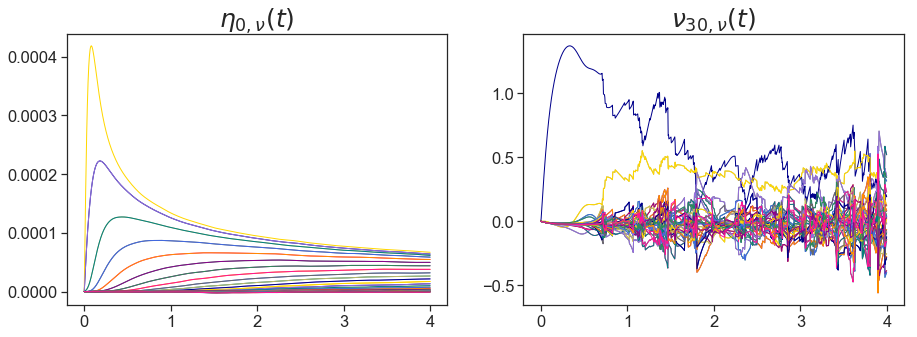

In [16]:
x = np.arange(0,nSteps * dtStress, dtStress)
plt.figure(1, figsize=(15,5))

plt.subplot(121)
for i in range(nNodes):
    plt.plot(x, Etat[30,i,:])
plt.title(r'$\eta_{0,\nu}(t)$', fontsize=25)

plt.subplot(122)
for i in range(nNodes):
    plt.plot(x, KinVisct[29,i,:])
plt.title(r'$\nu_{30,\nu}(t)$', fontsize=25)
plt.show()

#### Save files

# 2. FOURIER SPACE

## 2.1. Compute $\tilde{C}(t)_{\mu\nu}$, $\tilde{\dot{C}}_{\mu\nu}(t)$, $\tilde{C}^{-1}_{\mu\nu}(t)$, $\tilde{\Lambda}_{\mu\nu}(t)$, $\tilde{\nu}_{\mu\nu}$, $\tilde{\eta}_{\mu\nu}$ , $\tilde{\eta}^*_{\mu\nu}$, and $\eta^*(t)$

$\tilde{\eta}^*(t)=\frac{1}{k_BT\tilde{\Delta}\tilde{c}(t)}\frac{d\tilde{C}}{dt}$

$\tilde{\eta}_2^*(t)=\frac{\tilde{\eta}(t)}{\tilde{c}(t)}$

In [20]:
CtFourier        = np.zeros((nNodes, nNodes, nSteps))
CtNormFourier    = np.zeros((nNodes, nNodes, nSteps))
CtNormInvFourier = np.zeros((nNodes, nNodes, nSteps))
CtDevFourier     = np.zeros((nNodes, nNodes, nSteps))
CtInvFourier     = np.zeros((nNodes, nNodes, nSteps))
LambdatFourier   = np.zeros((nNodes, nNodes, nSteps))
KinVisctFourier  = np.zeros((nNodes, nNodes, nSteps))
EtatFourier      = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier2 = np.zeros((nNodes, nNodes, nSteps))
EtaStart         = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtFourier[:,:,k] = (EInv.dot(Ct[:,:,k]).dot(E)).real

C0Fourier = CtFourier[:,:,0]
RFourier  = linalg.pinv(C0Fourier, rcond = tol)

for i in range(nNodes):
    CtDevFourier[i,:,:] = ODev.dot(CtFourier[i,:,:].T).T

for k in range(nSteps):
    CtNormFourier[:,:,k]    = RFourier.dot(CtFourier[:,:,k])
    CtInvFourier[:,:,k]     = linalg.pinv(CtFourier[:,:,k], rcond = tol)
    CtNormInvFourier[:,:,k] = CtInvFourier[:,:,k].dot(C0Fourier)
    LambdatFourier[:,:,k]   = - CtDevFourier[:,:,k].dot(CtInvFourier[:,:,k])
    KinVisctFourier[:,:,k]  = - LaplacianInvFourier.dot(LambdatFourier[:,:,k])
    EtatFourier[:,:,k]      = (EInv.dot(Etat[:,:,k]).dot(E)).real
    EtaStartFourier[:,:,k]  = (1.0 / Temp) * \
                (LaplacianInvFourier.dot(CtFourier[:,:,0]).dot(CtInvFourier[:,:,k]).dot(CtDevFourier[:,:,k]))
    EtaStartFourier[0,0,k]  = (1.0 / nNodes) * np.sum(Etat[:,:,k/2])  # From (41) in Space and time locality...
    EtaStart[:,:,k] = E.dot(EtaStartFourier[:,:,k]).dot(EInv)      

for k in range(nSteps/2):
    EtaStartFourier2[:,:,k] = EtatFourier[:,:,k].dot(CtNormInvFourier[:,:,2*k]) 

for k in range(nSteps/2):
    EtaStartFourier2[0,0,k] = (1.0 / nNodes) * np.sum(Etat[:,:,k])  # From (41) in Space and time locality...

/Users/diego/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


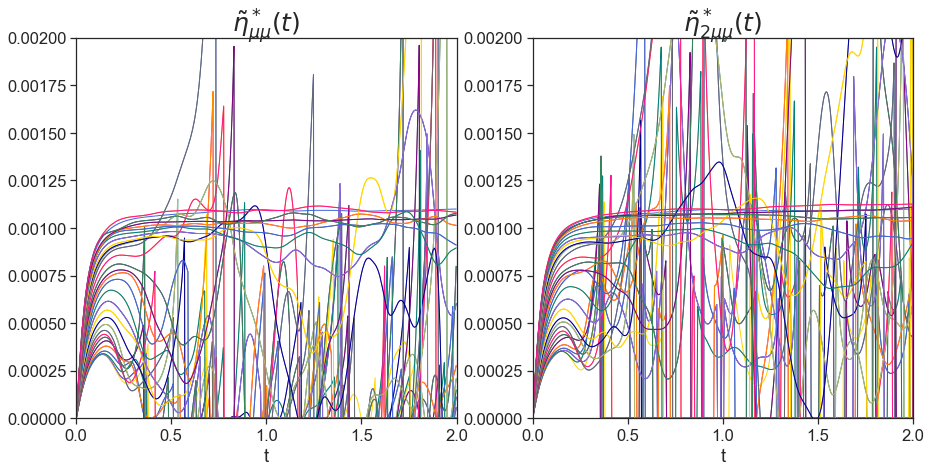

In [18]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
x = np.arange(0, nSteps * dt, dt)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier[i,i,:])
plt.title(r'$\tilde{\eta}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.002)

plt.subplot(122)
x = np.arange(0, nSteps * dtStress, dtStress)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2[i,i,:])
plt.title(r'$\tilde{\eta}^*_{2\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.002)
plt.show()

#### The same after chopping the matrix $\tilde{C}(t)$ $\to$ $\bar{\tilde{C}}(t)$

In [19]:
cutOffValue = 2e-5
#cutOffValue = 3e-5 #FIG. 10 
CtFourierChop        = np.zeros((nNodes, nNodes, nSteps))
CtNormFourierChop    = np.zeros((nNodes, nNodes, nSteps))
CtNormInvFourierChop = np.zeros((nNodes, nNodes, nSteps))
CtDevFourierChop     = np.zeros((nNodes, nNodes, nSteps))
CtInvFourierChop     = np.zeros((nNodes, nNodes, nSteps))
LambdatFourierChop   = np.zeros((nNodes, nNodes, nSteps))
KinVisctFourierChop  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourierChop  = np.zeros((nNodes, nNodes, nSteps))
EtaStartFourier2Chop = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtFourierChop[:,:,k] = cutOff((CtFourier[:,:,k]), cutOffValue)

for i in range(nNodes):
    CtDevFourierChop[i,:,:] = ODev.dot(CtFourierChop[i,:,:].T).T

for k in range(nSteps):
    CtInvFourierChop[:,:,k]     = linalg.pinv(CtFourierChop[:,:,k], rcond = tol)
    CtNormFourierChop[:,:,k]    = CtInvFourierChop[:,:,0].dot(CtFourierChop[:,:,k])
    CtNormInvFourierChop[:,:,k] = CtInvFourierChop[:,:,k].dot(CtFourierChop[:,:,0])
    LambdatFourierChop[:,:,k]   = - CtDevFourierChop[:,:,k].dot(CtInvFourierChop[:,:,k])
    KinVisctFourierChop[:,:,k]  = - LaplacianInvFourier.dot(LambdatFourierChop[:,:,k])
    EtaStartFourierChop[:,:,k]  = (1 / Temp) * \
            (LaplacianInvFourier.dot(CtFourierChop[:,:,0]).dot(CtInvFourierChop[:,:,k]).dot(CtDevFourierChop[:,:,k]))

#Como el paso de tiempo en el cálculo de las correlaciones del momento es 0.002 y el de las correlaciones del tensor
#de tensiones es 0.004, hay que tener cuidado cuando se multiple una variable que está obtenida a partir del tensor
#de tensiones por otra que provenga de las correlaciones del momento. 
for k in range(nSteps/2):
    EtaStartFourier2Chop[:,:,k] = EtatFourier[:,:,k].dot(CtNormInvFourierChop[:,:,2*k])

#Convert zeros to NaN's 
for k in range(nSteps):
    CtFourierChop[:,:,k]        = zeroToNan(CtFourierChop[:,:,k])
    CtNormFourierChop[:,:,k]    = zeroToNan(CtNormFourierChop[:,:,k])
    CtDevFourierChop[:,:,k]     = zeroToNan(CtDevFourierChop[:,:,k])
    CtInvFourierChop[:,:,k]     = zeroToNan(CtInvFourierChop[:,:,k])
    LambdatFourierChop[:,:,k]   = zeroToNan(LambdatFourierChop[:,:,k])
    KinVisctFourierChop[:,:,k]  = zeroToNan(KinVisctFourierChop[:,:,k])
    EtaStartFourierChop[:,:,k]  = zeroToNan(EtaStartFourierChop[:,:,k])
    EtaStartFourier2Chop[:,:,k] = zeroToNan(EtaStartFourier2Chop[:,:,k])

KeyboardInterrupt: 

In [ ]:
x = range(nNodes)

#tStart, tStop, tJump = 0, 0.22, 0.02
tStart, tStop, tJump = 0, 0.5, 0.02

plt.figure(1, figsize=(15,25))

plt.subplot(421)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(CtFourier[:,:,step(t)]), label = 't='+str(t)) 
    plt.plot(x, np.ones(nNodes) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(422)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(CtFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
#plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(423)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(LambdatFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(424)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(LambdatFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
#plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(425)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(EtaStartFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\eta}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(426)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(EtaStartFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\bar{\tilde{\eta}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
#plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(427)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(KinVisctFourier[:,:,step(t)]), label = 't='+str(t))
plt.title(r'$\tilde{\nu}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.subplot(428)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(KinVisctFourierChop[:,:,step(t)]), label = 't='+str(t))
plt.axhline(y=1.48, color="black")
plt.title(r'$\bar{\tilde{\nu}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel(r'$\mu$')
#plt.legend(loc='upper right', fontsize = 14)
plt.xlim(0,60)
plt.ylim(0,)

plt.tight_layout() #Improve spacing between subplots
plt.show()

In [ ]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,25))

plt.subplot(521)
for i in range(nNodes):
    plt.plot(x, CtFourier[i,i,:])
    plt.plot(x, np.ones(nSteps) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)

plt.subplot(522)
for i in range(nNodes):
    plt.plot(x, CtFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)

plt.subplot(523)
for i in range(nNodes):
    plt.plot(x, LambdatFourier[i,i,:])
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(-0.5,22)

plt.subplot(524)
for i in range(nNodes):
    plt.plot(x, LambdatFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(-0.5,22)

plt.subplot(525)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier[i,i,:])
plt.title(r'$\tilde{\eta}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

plt.subplot(526)
for i in range(nNodes):
    plt.plot(x, EtaStartFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\eta}}^*_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

x = np.arange(0, nSteps * dtStress, dtStress)
plt.subplot(527)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2[i,i,:])
plt.title(r'$\tilde{\eta^*2}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

plt.subplot(528)
for i in range(nNodes):
    plt.plot(x, EtaStartFourier2Chop[i,i,:])
plt.title(r'$\bar{\tilde{\eta^*2}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,0.0012)

x = np.arange(0, nSteps * dt, dt)
plt.subplot(529)
for i in range(nNodes):
    plt.plot(x, KinVisctFourier[i,i,:])
plt.title(r'$\tilde{\nu}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,1.7)

plt.subplot(5,2,10)
for i in range(nNodes):
    plt.plot(x, KinVisctFourierChop[i,i,:])
plt.title(r'$\bar{\tilde{\nu}}_{\mu\mu}(t)$', fontsize = 25)
plt.xlabel('t')
plt.xlim(0,2)
plt.ylim(0,1.7)

plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files

#### Plot $\tilde{C_{\mu\mu}}(t)$ for my thesis

In [ ]:
from matplotlib.ticker import FormatStrFormatter


x = range(nNodes)
tStart, tStop, tJump = 0, 0.22, 0.02
fig = plt.figure()
fig.set_size_inches(size1Fig)
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(CtFourier[:,:,step(t)]), color='royalblue') 
plt.xlim(0,60)
plt.ylim(0,1.5e-3)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tilde{C}_{\mu\mu}(t)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.savefig('../../../figures/CtFourier-PBC.pdf',dpi=1000, bbox_inches='tight')  
plt.show()

x = np.arange(0, nSteps * dt, dt)
fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
for i in range(nNodes):
    plt.plot(x, CtFourier[i,i,:], color='royalblue')
plt.axvline(x=tau, color = 'red')
plt.xlim(0,2)
plt.ylim(-5e-5,15e-4)
plt.xlabel('t')
plt.ylabel(r'$\tilde{C}_{\mu\mu}(t)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='plain', axis='x')
plt.subplot(122)
for i in range(nNodes):
    plt.semilogy(x[CtFourier[i,i,:]<cutOffValue], CtFourier[i,i,:][CtFourier[i,i,:]<cutOffValue], color='black', linestyle='dashed')
    plt.semilogy(x[CtFourier[i,i,:]>cutOffValue], CtFourier[i,i,:][CtFourier[i,i,:]>cutOffValue], color='royalblue')
plt.axvline(x=tau, color = 'red')
plt.axhline(y=cutOffValue, color = 'black')
plt.xlim(0,2)
plt.ylim(1e-6,2e-3)
plt.xlabel('t')
#plt.ylabel(r'$\tilde{C}_{\mu\nu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')

#plt.savefig('../../../figures/CtFourier-PBC-exp.pdf',dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
fig.set_size_inches(size1Fig)
for i in range(nNodes):
    x = np.arange(0, nSteps * dtStress, dtStress)
    #plt.plot(x[CtFourier[i,i,:]>cutOffValue], EtaStartFourier[i,i,:][CtFourier[i,i,:]>cutOffValue], color='royalblue')
    #plt.plot(x[CtFourier[i,i,:]<cutOffValue], EtaStartFourier[i,i,:][CtFourier[i,i,:]<cutOffValue], color='black', linestyle='dashed', alpha=0.1)
    plt.plot(x, EtaStartFourier2Chop[i,i,:], color='royalblue')
    #plt.plot(x, EtaStartFourier2[i,i,:], color='black', alpha=0.1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0, 2])
plt.ylim([0, 1.5e-3])
plt.xlabel('t')
plt.ylabel(r'$\tilde{\eta}^*_{\mu\mu}(t)$')
#plt.savefig('../../../figures/EtaStartFourier-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

x = range(nNodes)
fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
tStart, tStop, tJump = 0, 0.21, 0.01
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(KinVisctFourier[:,:,step(t)]), color = "royalblue")
plt.axhline(y=1.48, color='darkorange')
plt.ylabel(r'$\tilde{\nu}_{\mu}(t)$')
plt.xlabel(r'$\mu$')
plt.xlim(0,60)
plt.ylim(0,2)
plt.subplot(122)
x = np.arange(0, nSteps * dt, dt)
for i in range(nNodes):
    plt.plot(x[CtFourier[i,i,:]>cutOffValue], KinVisctFourier[i,i,:][CtFourier[i,i,:]>cutOffValue], color='royalblue')
    #plt.plot(x[CtFourier[i,i,:]<cutOffValue], KinVisctFourier[i,i,:][CtFourier[i,i,:]<cutOffValue], color='black', linestyle='dashed', alpha=0.1)
plt.axhline(y=1.48, color='darkorange')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.xlabel('t')
#plt.savefig('../../../figures/KinVisctFourier-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

## 2.2. Compare $\eta^*(\tau)$ and $\eta(\tau)$

In [ ]:
fig = plt.figure()
fig.set_size_inches(size1Fig)
plt.plot(Etat[30,:,step(tau)])
plt.plot(EtaStart[30,:,step(tau)])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0, 60])
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\eta^*_{30\nu}, \eta_{30\nu}(\tau)$')
#plt.savefig('../../../figures/CompareEtas-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

## 2.3. Compute $\tilde{\Lambda}_{\mu\mu}^{\rm loc}$ and compare with $\tilde{\Lambda}_{\mu\mu}$ 

In [ ]:
LambdaLoc = np.zeros(nNodes)
for i in range(nNodes):
    LambdaLoc[i] = 2 / dz**2 * (1-np.cos(2*np.pi*i/nNodes)) * 1.48

In [ ]:
fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
x = range(nNodes)
tStart, tStop, tJump = 0, 0.22, 0.02
for t in np.arange(tStart, tStop, tJump):
    plt.plot(x, np.diag(LambdatFourier[:,:,step(t)]), color='royalblue') 
    plt.plot(LambdaLoc, color='darkorange')
plt.xlim(0,60)
plt.ylim(0,25)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

x = np.arange(0, nSteps * dt, dt)
plt.subplot(122)
for i in range(nNodes):
    plt.plot(x[CtFourier[i,i,:]>cutOffValue], LambdatFourier[i,i,:][CtFourier[i,i,:]>cutOffValue], color='royalblue')
    #plt.plot(x[CtFourier[i,i,:]<cutOffValue], LambdatFourier[i,i,:][CtFourier[i,i,:]<cutOffValue], color='black', linestyle='dashed', alpha=0.1)
plt.axvline(x=0.2, color = 'red')
#plt.axhline(y=cutOffValue, color = 'black')
plt.xlim(0,2)
plt.ylim(0,25)
plt.xlabel('t')
#plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')

#plt.savefig('../../../figures/LambdatFourier-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

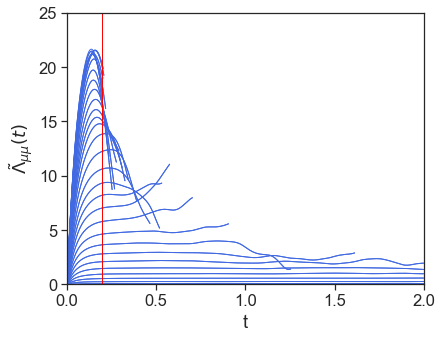

In [25]:
# Grafico defensa

fig = plt.figure()
fig.set_size_inches(size1Fig)
x = np.arange(0, nSteps * dt, dt)
for i in range(nNodes):
    plt.plot(x[CtFourier[i,i,:]>cutOffValue], LambdatFourier[i,i,:][CtFourier[i,i,:]>cutOffValue], color='royalblue')
    #plt.plot(x[CtFourier[i,i,:]<cutOffValue], LambdatFourier[i,i,:][CtFourier[i,i,:]<cutOffValue], color='black', linestyle='dashed', alpha=0.1)
plt.axvline(x=0.2, color = 'red')
#plt.axhline(y=cutOffValue, color = 'black')
plt.xlim(0,2)
plt.ylim(0,25)
plt.xlabel('t')
plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')

plt.savefig('../../../figures/LambdatFourier-PBC-defense.pdf',dpi=1000, bbox_inches='tight')
plt.show()


In [ ]:
LambdaCompare = np.zeros((nNodes,2))
LambdaCompare[:,0] = np.diag(LambdatFourier[:,:,step(0.2)])
LambdaCompare[:,1] = LambdaLoc

In [ ]:
fig = plt.figure()
fig.set_size_inches(size1Fig)
plt.plot(LambdaCompare[:,0], LambdaCompare[:,1])
line = range(21)
plt.plot(line, line, c='red')
plt.xticks(np.arange(min(line), max(line)+1, 5.0))
plt.yticks(np.arange(min(line), max(line)+1, 5.0))
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xlabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}^{\rm loc}(t)$')
#plt.savefig('../../../figures/CompareLambdas-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()

#### Save files

## 2.4. Compute $\tilde{\eta}_{00}(t)$, $\eta_{0}(t)$ and $\nu_{0}(t)$ for support t=30

$\tilde{\eta}_{00}(t)=\frac{1}{N_{bin}}\sum_{\mu\nu}\eta_{\mu\nu}(t)$

$\eta_{0}(t) = \frac{V_T}{N_{bin}}\cdot\tilde{\eta}_{00}(t)$

$\nu_{0}(t)=\frac{\eta_{0}(t)}{\rho}$

In [ ]:
SxztLong = np.loadtxt('Sxzt-PBC.dat')

In [ ]:
nStepsLong = np.shape(SxztLong)[0]

Eta00t  = np.zeros(nStepsLong)
for k in range(nStepsLong):
    EtatLong = (1 / Temp) * reshape_vm(np.trapz(SxztLong[0:k+1,:], dx=dtStress, axis=0))
    Eta00t[k] = np.sum(EtatLong)
    
Eta00t   /= nNodes
Eta0t     = Eta00t * Vol  / nNodes
KinVisc0t = Eta0t / density

In [ ]:
EtatLong     = np.zeros((nNodes, nNodes, nStepsLong))

for k in range(nStepsLong):
    EtatLong[:,:,k]     = reshape_vm(np.trapz(SxztLong[0:k+1,:], dx=dtStress, axis=0))
EtatLong /= Temp

In [ ]:
x = np.arange(0,nStepsLong * dtStress, dtStress)

fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
plt.plot(x,Eta00t)
plt.title(r'$\tilde{\eta}_{00}(t)$')
plt.subplot(122)
plt.plot(x,Eta0t)
plt.title(r'$\eta_{0}(t)$')
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(size2Fig))
for i in range(30,40,1):
    ax1.plot(x, EtatLong[30,i,:], color="royalblue")
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.set_xlim([0, 30])
    ax1.set_ylim([0, 4.5e-4])
    ax1.set_xlabel('t')
    ax1.set_ylabel(r'$\eta_{\mu\nu}(t)$')
    
    ax2.loglog(x, EtatLong[30,i,:], color="royalblue")
    ax2.set_xlim([0, 30])
    ax2.set_ylim([1e-6, 4.5e-4])
    ax2.set_xlabel('t')
# inset
box            = ax1.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax1.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5
with sns.axes_style("ticks"):
    subax          = fig.add_axes([pos_x,pos_y,width,height])
    for i in range(30,40,1):
        subax.plot(x, EtatLong[30,i,:], color="royalblue")
        subax.set(xlim=[0,1], ylim=[0, 4.5e-4])
        subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        subax.axvline(x=0.2, color = 'red')
#plt.savefig('../../../figures/Etat-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()


fig = plt.figure()
fig.set_size_inches(size1Fig)
# main figure
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])          # main axes
ax1.plot(x, KinVisc0t)
ax1.plot(x, 1.48*np.ones(nStepsLong), color='darkorange')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xlim([-0.1, 30])
ax1.set_ylim([0, 1.6])
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\nu_0(t)$')
# inset
with sns.axes_style("ticks"):
    left, bottom, width, height = 0.45, 0.25, 0.4, 0.45
    ax2 = fig.add_axes([left, bottom, width, height]) # inset axes
    ax2.plot(x, KinVisc0t)
    ax2.plot(x, 1.48*np.ones(nStepsLong), color='darkorange')
    ax2.axvline(x=0.2, color = 'red')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1.6])
#plt.savefig('../../../figures/KinVisc0t-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()


#### Save files

# 3. PREDICTIONS 

From the figures we may considerer that $\tilde{\Lambda}(t)$ has a plateau. We select $\tau=0.2$ as the best compromise satisfaying that $\Lambda(t)$ has attained its constant value. Therefore 

$C^{predict}(t) = exp[-\Lambda(\tau)·(t-\tau)]C(\tau)$ 

## 3.1. Compute predictions

In [24]:
tau = 0.2
v0 = 1.48
CtPredict      = np.zeros((nNodes, nNodes, nStepsPred))
CtPredictLocal = np.zeros((nNodes, nNodes, nStepsPred))
for k in range(nStepsPred):
    t = k * dt
    CtPredict[:,:,k]      = expm(- Lambdat[:,:,step(tau)] * (t - tau)).dot(Ct[:,:,step(tau)])
    CtPredictLocal[:,:,k] = expm(v0 * Laplacian * (t - tau)).dot(Ct[:,:,step(tau)])

## 3.2. Plot $C(t)$ and the predictions

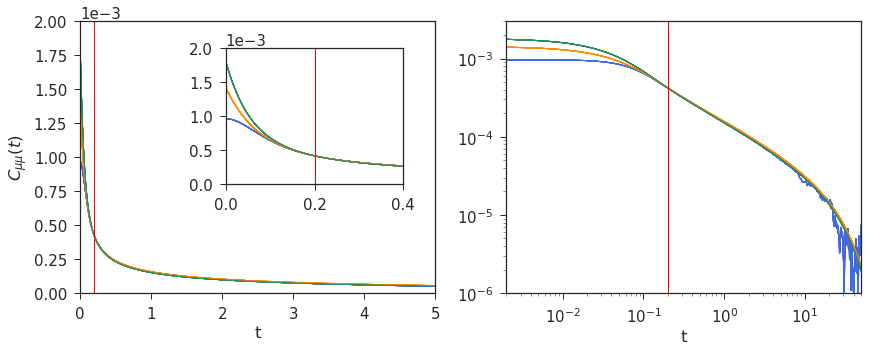

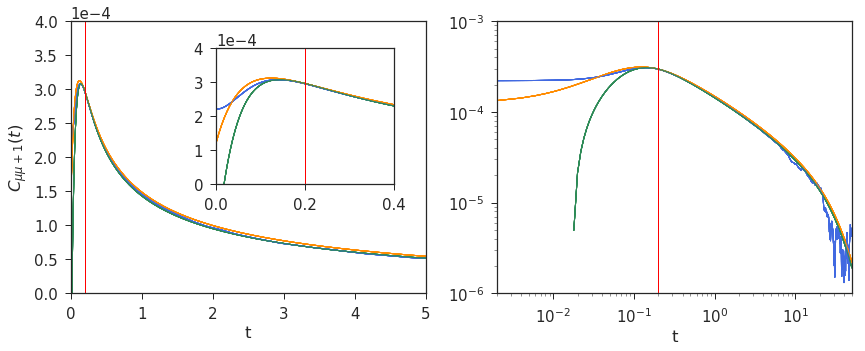

In [15]:
#Autocorrelation   #The for loop do not do anything. They are here in the case I need them.
x   = np.arange(0, nStepsPred * dt, dt)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(size2Fig))
for i in range(30,40,1):
    ax1.plot(x, Ct_mu30nu30, c='royalblue')
    ax1.plot(x, CtPredict[30,30,:], c='darkorange')
    ax1.plot(x, CtPredictLocal[30,30,:], c='seagreen')
    ax1.axvline(x=0.2, color = 'red')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.set_xlim([0, 5])
    ax1.set_ylim([0, 2e-3])
    ax1.set_xlabel('t')
    ax1.set_ylabel(r'$C_{\mu\mu}(t)$')
    
    ax2.loglog(x, Ct_mu30nu30, c='royalblue')
    ax2.loglog(x, CtPredict[30,30,:], c='darkorange')
    ax2.loglog(x, CtPredictLocal[30,30,:], c='seagreen')
    ax2.axvline(x=0.2, color = 'red')
    ax2.set_xlim([0, 50])
    ax2.set_ylim([1e-6, 3e-3])
    ax2.set_xlabel('t')
# inset
box            = ax1.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax1.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5
with sns.axes_style("ticks"):
    subax          = fig.add_axes([pos_x,pos_y,width,height])
    for i in range(30,40,1):
        subax.plot(x, Ct_mu30nu30, c='royalblue')
        subax.plot(x, CtPredict[30,30,:], c='darkorange')
        subax.plot(x, CtPredictLocal[30,30,:], c='seagreen')
        subax.set(xlim=[0,0.4], ylim=[0, 2e-3])
        subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        subax.axvline(x=0.2, color = 'red')
#plt.savefig('../../../figures/Predictionsmumu-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()


#Cross correlation
x   = np.arange(0, nStepsPred * dt, dt)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(size2Fig))
for i in range(30,40,1):
    ax1.plot(x, Ct_mu30nu31, c='royalblue')
    ax1.plot(x, CtPredict[30,31,:], c='darkorange')
    ax1.plot(x, CtPredictLocal[30,31,:], c='seagreen')
    ax1.axvline(x=0.2, color = 'red')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.set_xlim([0, 5])
    ax1.set_ylim([0, 4e-4])
    ax1.set_xlabel('t')
    ax1.set_ylabel(r'$C_{\mu\mu+1}(t)$')
    
    ax2.loglog(x, Ct_mu30nu31, c='royalblue')
    ax2.loglog(x, CtPredict[30,31,:], c='darkorange')
    ax2.loglog(x, CtPredictLocal[30,31,:], c='seagreen')
    ax2.axvline(x=0.2, color = 'red')
    ax2.set_xlim([0, 50])
    ax2.set_ylim([1e-6, 1e-3])
    ax2.set_xlabel('t')
# inset
box            = ax1.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax1.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5
with sns.axes_style("ticks"):
    subax          = fig.add_axes([pos_x,pos_y,width,height])
    for i in range(30,40,1):
        subax.plot(x, Ct_mu30nu31, c='royalblue')
        subax.plot(x, CtPredict[30,31,:], c='darkorange')
        subax.plot(x, CtPredictLocal[30,31,:], c='seagreen')
        subax.set(xlim=[0,0.4], ylim=[0, 4e-4])
        subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        subax.axvline(x=0.2, color = 'red')
#plt.savefig('../../../figures/Predictionsmumu+1-PBC.pdf',dpi=1000, bbox_inches='tight')
plt.show()


#### Save files

In [26]:
#np.savetxt('../../filesGNUPLOT/CtPredict-mu30nu31-PBC-t30.dat', CtPredict[29,30,:])
#np.savetxt('../../filesGNUPLOT/CtPredictLocal-mu30nu31-PBC-t30.dat', CtPredictLocal[29,30,:])

# Appendix

In [3]:
g2 = np.loadtxt('Plot02-GreenFunctionGmu0-112-224-448.dat')
g3 = np.loadtxt('Plot03-GreenFunctionGmu0Lz-112-224-448.dat')

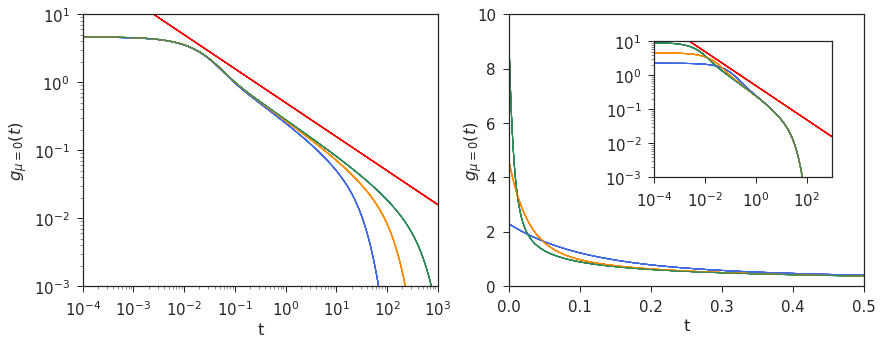

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(size2Fig))
for i in range(30,40,1):
    ax1.loglog(g2[:,1], g2[:,2], color = "royalblue")
    ax1.loglog(g2[:,1], g2[:,3], color = "darkorange")
    ax1.loglog(g2[:,1], g2[:,4], color='seagreen')
    ax1.loglog(g2[:,1], g2[:,5], color='red')
    ax1.set_ylabel(r'$g_{\mu=0}(t)$')
    ax1.set_xlabel('t')
    ax1.set_xlim(1e-4,1e3)
    ax1.set_ylim(1e-3,1e1)
    
    ax2.plot(g3[:,1], g3[:,2], color = "royalblue")
    ax2.plot(g3[:,1], g3[:,3], color = "darkorange")
    ax2.plot(g3[:,1], g3[:,4], color='seagreen')
    #plt.plot(g3[:,1], g3[:,5], color='red')
    ax2.set_ylabel(r'$g_{\mu=0}(t)$', labelpad=-8)
    ax2.set_xlabel('t')
    ax2.set_xlim(0,5e-1)
    ax2.set_ylim(0,1e1)
# inset
box            = ax2.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax2.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5
with sns.axes_style("ticks"):
    subax          = fig.add_axes([pos_x,pos_y,width,height])
    for i in range(30,40,1):
        subax.loglog(g3[:,1], g3[:,2], color = "royalblue")
        subax.loglog(g3[:,1], g3[:,3], color = "darkorange")
        subax.loglog(g3[:,1], g3[:,4], color='seagreen')
        subax.loglog(g3[:,1], g3[:,5], color='red')
        subax.set(xlim=[1e-4,1e3], ylim=[1e-3,1e1])
        #subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #subax.axvline(x=0.2, color = 'red')
plt.savefig('../../../figures/Green.pdf',dpi=1000, bbox_inches='tight')
plt.show()